In [271]:
typeof="mlp"

In [272]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import shutil
import torch
from torch import nn
import torch.utils.data
import torch.optim as optim
import random
import time

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()


root_path="../input/ecg-data-mit-arrhythmia-ptb"
cuda=torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
    
class opt:
    batch_size=64
    workers=2
    lr=0.001
    normal_train_path=root_path+"/normal_train.csv"
    normal_valid_path=root_path+"/normal_valid.csv"
    patient_valid_path=root_path+"/patient_valid.csv"
    
    
#change this
from models import KLAutoencoder,KLLSTMEncoder,KLMLPAutoencoder
from models import loss_function_kl as loss_function
def import_model(typeof):
    
    if(typeof=="lstm"):
        network=KLLSTMEncoder().to(device)
        network.load_state_dict(torch.load("../models/kllstm.pt",map_location="cpu"))        
        return network
    
    if(typeof=="conv"):
        network=KLAutoencoder().to(device)
        network.load_state_dict(torch.load("../models/klconv.pt",map_location="cpu")) 
        return network
    
    if(typeof=="mlp"):
        network=KLMLPAutoencoder().to(device)
        network.load_state_dict(torch.load("../models/klmlp.pt",map_location="cpu")) 
        return network
        
network=import_model(typeof)

In [273]:
class ECGTestDataset(torch.utils.data.Dataset):
    
    def __init__(self,path,disease_type):
        self.data=pd.read_csv(path,header=None)
        
        #all values of specific disease
        if(disease_type!=-1):
            self.data=self.data[self.data[187]==disease_type].values[:,:187]
        
        #equal values from all disease
        else:
            how_many=20
            temp=np.zeros(shape=(6*how_many,187))
            for i in range(6):
                temp[i*how_many:(i+1)*how_many,:]=self.data[self.data[187]==i].values[:how_many,:187]
                
            self.data=temp
          
        print(self.data.shape)
        
    def __getitem__(self,idx):
        x=self.data[idx,:187] # removed the label
        return x
    
    def __len__(self):
        return len(self.data)
    
normal_valid_dset=ECGTestDataset(opt.normal_valid_path,10)
testloader=torch.utils.data.DataLoader(normal_valid_dset,
                                       batch_size=1,
                                       shuffle=True,
                                        num_workers=opt.workers)

abnormal_valid_dset=ECGTestDataset(opt.patient_valid_path,-1)
validloader=torch.utils.data.DataLoader(abnormal_valid_dset,
                                       batch_size=1,
                                       shuffle=True,
                                        num_workers=opt.workers)

(120, 187)
(120, 187)


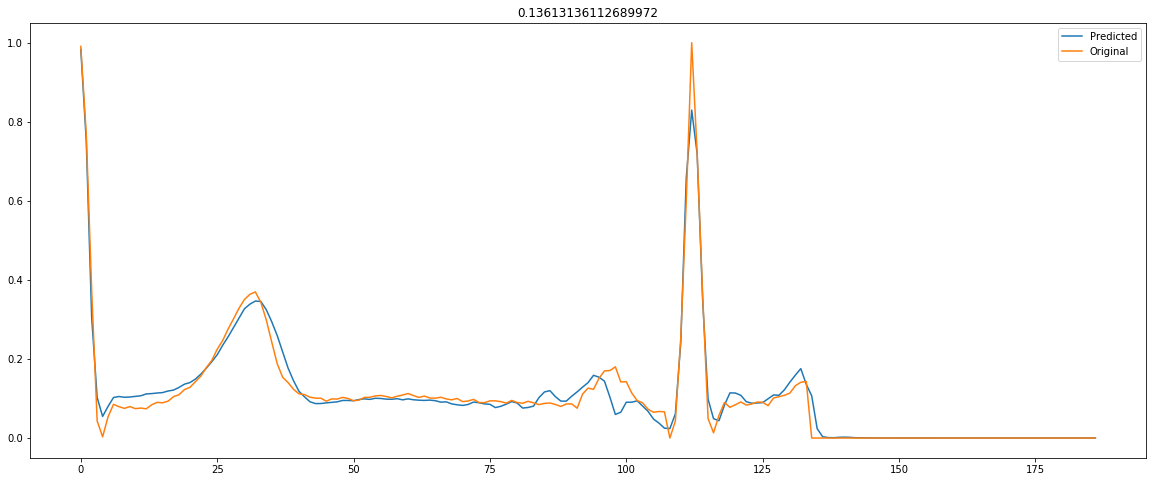

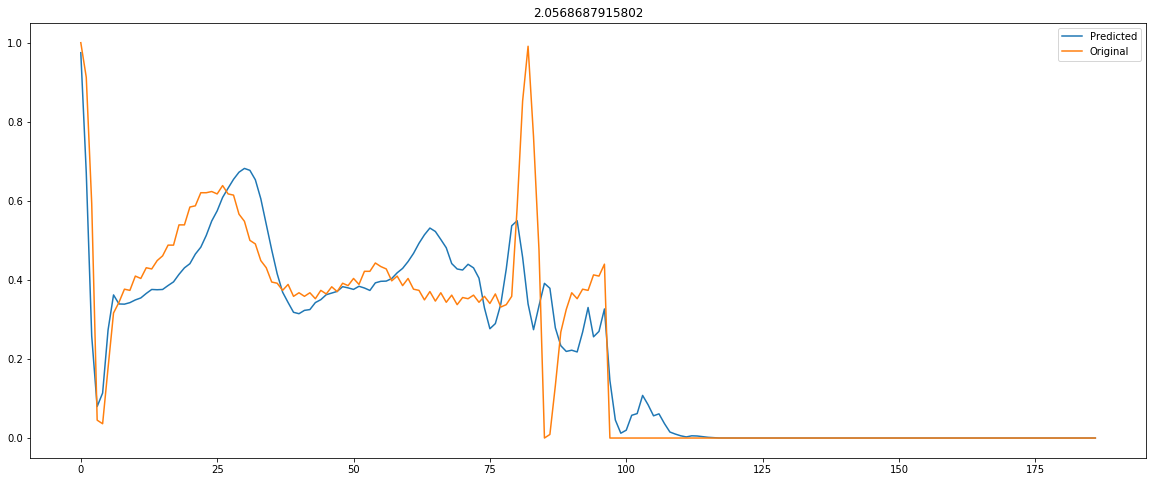

In [274]:
def plot_signal(loader):
    network.eval()
    for i,signal in enumerate(loader):
        signal=signal.to(device).float()
        output=network(signal)
        loss=loss_function(output,signal)
        break

    s1=output[0][0]
    s2=signal[0]
    
    plt.figure(figsize=(20,8))
    plt.plot(list(range(187)),s1.detach().cpu().numpy(),label="Predicted")
    plt.plot(list(range(187)),s2.detach().cpu().numpy(),label="Original")
    plt.title(loss.item())
    plt.legend()
    
plot_signal(testloader)
plot_signal(validloader)

In [275]:
def get_loss(loader):
    network.eval()
    total_loss=[]
    for i,signal in enumerate(loader):
        signal=signal.to(device).float()
        output=network(signal)
        loss=loss_function(output,signal)
        total_loss.append(loss.item())

    return np.array(total_loss)

def normalize_loss(loss,doit=True):
    if(not doit):
        return loss
    global maxl,minl
    loss=(loss-minl)/(maxl-minl)
    return loss

test_loss=get_loss(testloader)
valid_loss=get_loss(validloader)
maxl=max(test_loss.max(),valid_loss.max())
minl=min(test_loss.min(),valid_loss.min())

test_loss=normalize_loss(test_loss)
valid_loss=normalize_loss(valid_loss)

In [276]:
def find_optimal_threshold(test_loss,valid_loss):
    
    optimal_threshold=0
    optimal_fscore=0
    
    for threshold in np.arange(0,1,0.01):
        normal_pred=[]
        for x in test_loss:
            pred=1 if x>threshold else 0
            normal_pred.append(pred)

        patient_pred=[]
        for x in valid_loss:
            pred=1 if x>threshold else 0
            patient_pred.append(pred)

        normal_pred=np.array(normal_pred)
        normal_true=np.zeros_like(normal_pred)
        patient_pred=np.array(patient_pred)
        patient_true=np.ones_like(patient_pred)

        tp=sum(patient_pred)
        fp=sum(normal_pred)
        tn=len(normal_pred)-fp
        fn=len(patient_pred)-tp
        
        
        precision=tp/(tp+fp)
        recall=tp/(tp+fn)
        fscore=(2*(precision*recall))/(precision+recall)
        
        if(fscore>optimal_fscore):
            optimal_fscore=fscore
            optimal_threshold=threshold
        
    return optimal_threshold

In [277]:
def print_metrics(test_loss,valid_loss,threshold,beta=1):
    

    normal_pred=[]
    for x in test_loss:
        pred=1 if x>threshold else 0
        normal_pred.append(pred)

    patient_pred=[]
    for x in valid_loss:
        pred=1 if x>threshold else 0
        patient_pred.append(pred)

    normal_pred=np.array(normal_pred)
    normal_true=np.zeros_like(normal_pred)
    patient_pred=np.array(patient_pred)
    patient_true=np.ones_like(patient_pred)

    tp=sum(patient_pred)
    fp=sum(normal_pred)
    tn=len(normal_pred)-fp
    fn=len(patient_pred)-tp

    accuracy_normal=tn/len(normal_pred)
    accuracy_patient=tp/len(patient_pred)
    accuracy_total=(tp+tn)/(len(normal_pred)+len(patient_pred))

    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    num=(1+beta**2)*(precision*recall)
    den=((beta**2)*precision)+recall
    fscore=num/den

    print(f"Accuracy Normal: {accuracy_normal*100:.2f}%")
    print(f"Accuracy Patient: {accuracy_patient*100:.2f}%")
    print(f"Accuracy Total: {accuracy_total*100:.2f}%")

    print(f"Precision : {precision:.3f}")
    print(f"Recall : {recall:.3f}")
    print(f"Fscore : {fscore:.3f}")
    
    
threshold=find_optimal_threshold(test_loss,valid_loss)
print_metrics(test_loss,valid_loss,threshold,1)

Accuracy Normal: 85.83%
Accuracy Patient: 86.67%
Accuracy Total: 86.25%
Precision : 0.860
Recall : 0.867
Fscore : 0.863


(200, 187)
(200, 187)
(200, 187)
(200, 187)
(200, 187)
(200, 187)


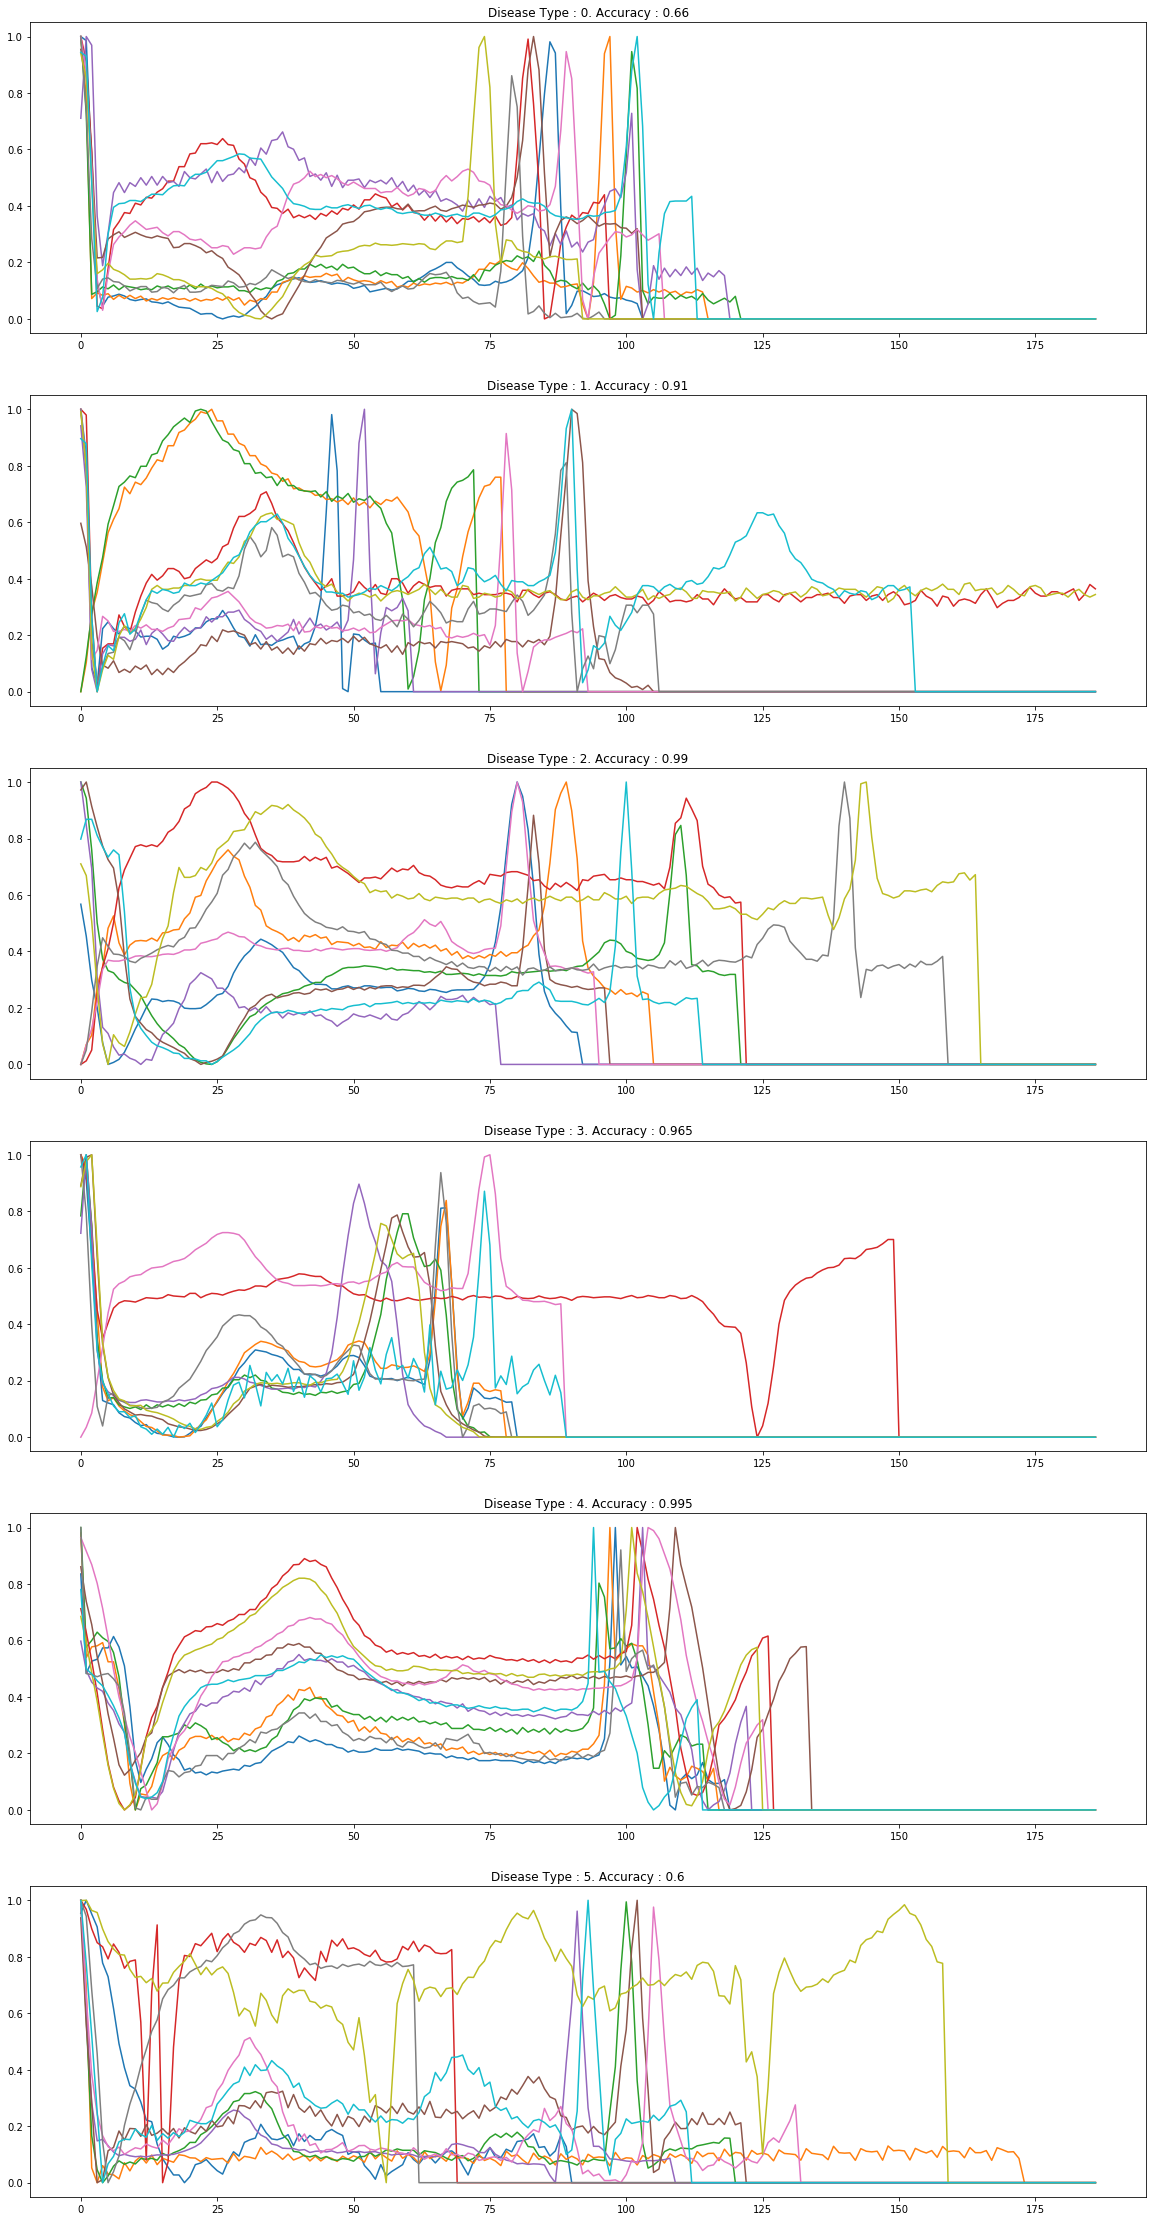

In [32]:
# disease wise prediction
def predict_disease_wise():
    df=pd.read_csv(opt.patient_valid_path,header=None)
    plt.figure(figsize=(20,40))

    for i in range(6):
        abnormal_valid_dset=ECGTestDataset(opt.patient_valid_path,i)
        validloader=torch.utils.data.DataLoader(abnormal_valid_dset,
                                               batch_size=1,
                                               shuffle=True,
                                                num_workers=opt.workers)

        valid_loss=normalize_loss(get_loss(validloader))
        patient_pred=[]
        for x in valid_loss:
            pred=1 if x>threshold else 0
            patient_pred.append(pred)

        acc=sum(patient_pred)/len(patient_pred)
        plt.subplot(6,1,i+1)
        plt.plot(df[df[187]==i].iloc[:10,:187].T.values)
        plt.title(f"Disease Type : {i}. Accuracy : {acc}")
    plt.show()

predict_disease_wise()

In [ ]:
Disease wise prediction